In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "/media/ssd/bbws_drone/segment-anything-2-real-time/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

/home/naufal/miniconda3/envs/sam2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

In [6]:
image_path = "/media/ssd/bbws_drone/Grounded-SAM-2/data/DJI_0262_Images"
images_paths = sorted([os.path.join(image_path, img_name) for img_name in os.listdir(image_path)])

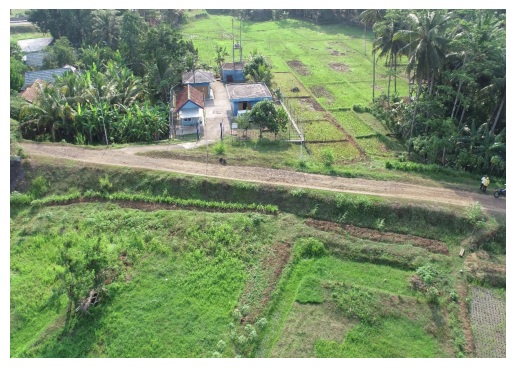

In [7]:
# Load the first image
image = Image.open(images_paths[0])
image = np.array(image)

# Show the image
plt.imshow(image)
plt.axis("off")
plt.show()

In [19]:
# Predict the bounding boxes using OWL-V2
prompts = [["building"]]
inputs = processor(text=prompts, images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.shape[:2]]).repeat(len(prompts), 1)

# Convert outputs (bounding boxes and class logits) to Pascal VOC Format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = prompts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected building with confidence 0.284 at location [19.93, 118.29, 144.61, 174.16]
Detected building with confidence 0.217 at location [355.29, 125.3, 424.7, 188.61]
Detected building with confidence 0.219 at location [449.81, 150.37, 535.69, 224.61]
Detected building with confidence 0.269 at location [333.51, 155.01, 404.84, 256.37]


19.92955 118.29482 124.67883 55.865776
355.2914 125.297295 69.40704 63.31115
449.80557 150.37439 85.88791 74.23389
333.50638 155.00502 71.33038 101.36568


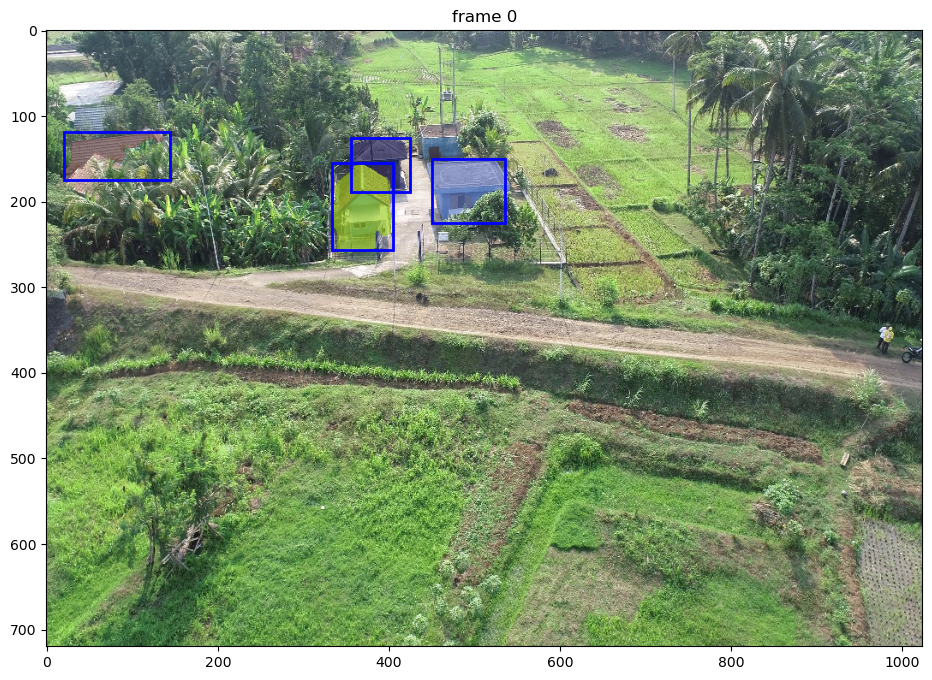

In [38]:
# Add first frame to sam2 predictor
predictor.load_first_frame(image)
ann_frame_idx = 0

plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(image)

for ann_obj_id, (box, score, label) in enumerate(zip(boxes, scores, labels)):
    bbox = np.array([box[:2], box[2:]])
    _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
        frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=bbox
    )
    show_bbox(bbox, plt.gca())


for obj_id, mask_logits in enumerate(out_mask_logits.cpu().numpy()):
    show_mask((mask_logits > 0.0), plt.gca(), obj_id=obj_id, random_color=True)
    

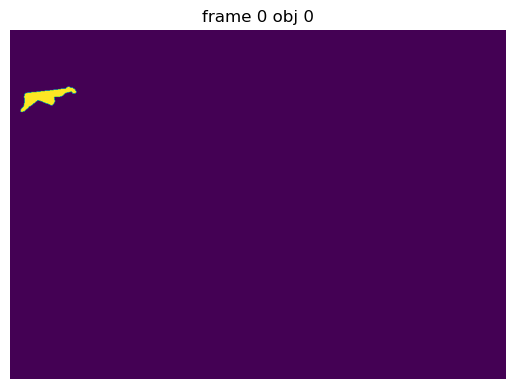

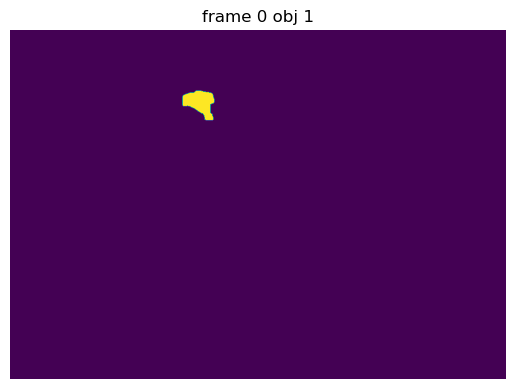

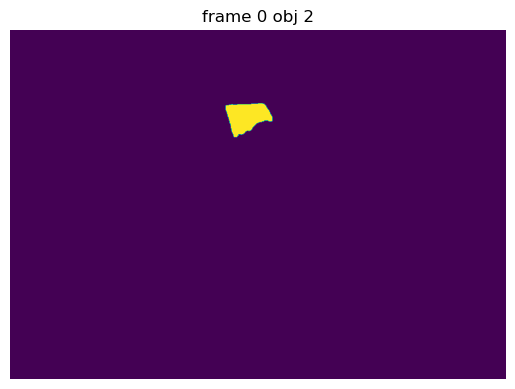

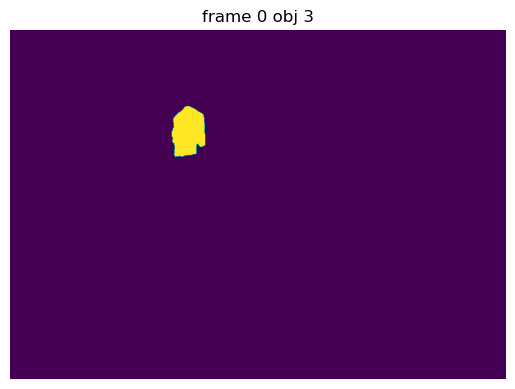

In [37]:
# Plot each out_mask_logits
for obj_id, mask_logits in enumerate(out_mask_logits.cpu().numpy()):
    plt.figure()
    plt.title(f"frame {ann_frame_idx} obj {obj_id}")
    plt.imshow(mask_logits[0] > 0.0)
    plt.axis("off")
    plt.show()


In [ ]:
# Plot each mask logits


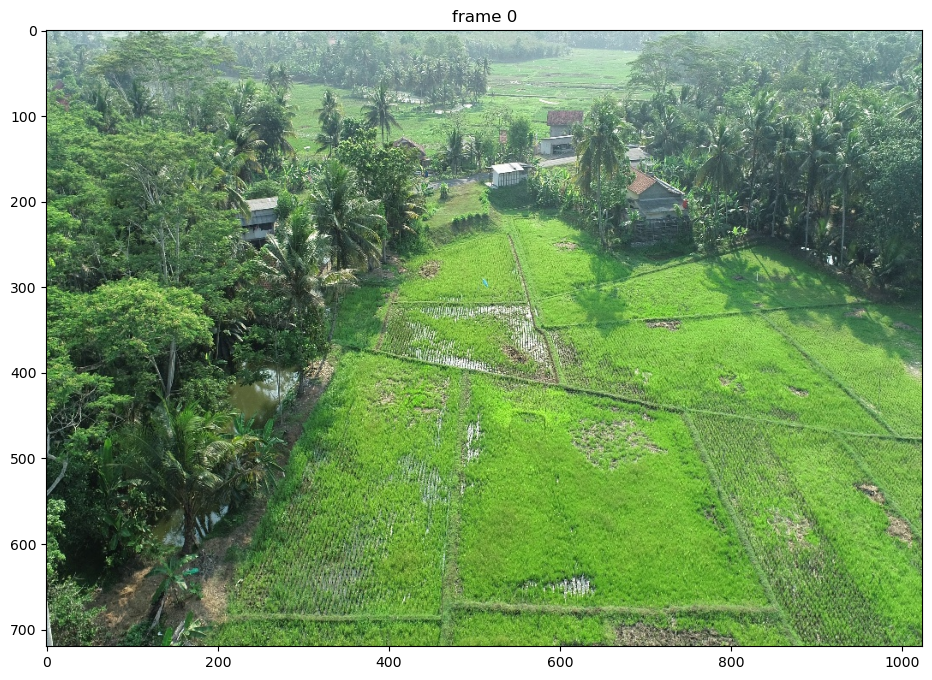

In [33]:
vis_gap = 30

for frame_idx, image_path in enumerate(images_paths):
    frame = cv2.imread(image_path)
    width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)

    if frame_idx % vis_gap == 0:
        print(f"frame {frame_idx}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(f"frame {ann_frame_idx}")
        plt.imshow(frame)
        
        for obj_id, mask_logits in enumerate(out_mask_logits.cpu().numpy()):
            show_mask((mask_logits > 0.0), plt.gca(), obj_id=obj_id)

        plt.show()


In [ ]:
# TODO: Redetect every certain frame and check if the new object is not located in the tracked object given IOU threshold then add it to the tracker